In [70]:
%matplotlib inline

import pandas as pd
import numpy as np
import os
import bayes_net_utils as bn
import matplotlib.pyplot as plt

plt.style.use('ggplot')

# Introduction and read in data

Notebook for carrying out visual and statistical comparison of observed and predicted seasonal water chemistry and ecology in Vanemfjorden. Takes predictions produced by notebook Predict_with_BN.ipynb and either compares predictions produced using different kinds of met data, or compares predictions to observations from the lake. 

In [71]:
# Paths to files and folders
obs_fpath = '../Data/DataMatrices/Seasonal_BN_obs/seasonal_obs_GBN_1981-2019.csv'
sim_era5_fpath = '../Data/Predictions/Historic/GBN_prediction_era5_1981-2019.csv'
sim_s5_folder = '../Data/Predictions/Historic/s5'

In [72]:
# Read in the observations
obs_wide = pd.read_csv(obs_fpath)

# The tercile plot function can't cope with NaNs, so fill these
# Fill NaNs in water chemistry and ecology (linearly interpolate and backwards fill)
obs_wide.interpolate(method='linear',limit=1, inplace=True)
obs_wide['colour'] = obs_wide['colour'].fillna(method='bfill', limit=2)

# Reformat obs to long format, same as the others
obs = pd.melt(obs_wide, id_vars=['year'], value_vars=['TP','chla','colour','cyano'],
         var_name='node', value_name='obs')

obs.columns = ['year','node','value']

obs.head()

,year,node,value
0,1981,TP,28.833333
1,1982,TP,26.988095
2,1983,TP,29.781250
3,1984,TP,26.527500
4,1985,TP,30.957143


In [73]:
# Read in predictions driven by ERA5 met data ('pseudoobs') and reformat to same format as obs
sim_era5 = pd.read_csv(sim_era5_fpath)

# Pick out just the expected value
sim_era5_e = sim_era5[['year','node','expected_value']]
sim_era5_e.columns = ['year','node','value'] # Rename columns
sim_era5_e.head()

,year,node,value
0,1981,chla,19.30
1,1981,colour,28.80
2,1981,cyano,2.09
3,1981,TP,37.00
4,1982,chla,11.10


In [74]:
# Read in BN predictions driven by s5 and reformat

member_li = ["%.2d" % i for i in range(1,26)] # List of S5 member numbers in format '01','02'... Should be present in s5 met data folder
season_li = ['summer', 'late_summer'] # Seasons of interest (must match filenames in s5 met data folder)
st_yr = 1993
end_yr = 2019

sim_s5_dict = {} # key: season, returns df with cols yr, node, expected values from member 01, 02, 03,...
for season in season_li:
    expected_value_li = []
    for member in member_li:

        # Read in predictions for this season and member
        s5fname = 'GBN_prediction_s5_%s-%s_%s_%s.csv' %(st_yr, end_yr, season, member)
        s5fpath = os.path.join(sim_s5_folder, s5fname)
        sim_s5 = pd.read_csv(s5fpath)
        
        # Extract just the expected value, rename, and add to list
        expected_values = sim_s5['expected_value']
        expected_values.name = 'sim_s5_%s' %member
        expected_value_li.append(expected_values)
    
    # Make dataframe and add to expected values dict for s5
    sim_s5_e = pd.concat([sim_s5[['year','node']]]+expected_value_li, axis=1)
    sim_s5_dict[season] = sim_s5_e

# Check of output
sim_s5_dict['summer'].head()

,year,node,sim_s5_01,sim_s5_02,sim_s5_03,sim_s5_04,sim_s5_05,sim_s5_06,sim_s5_07,sim_s5_08,...,sim_s5_16,sim_s5_17,sim_s5_18,sim_s5_19,sim_s5_20,sim_s5_21,sim_s5_22,sim_s5_23,sim_s5_24,sim_s5_25
0,1993,chla,14.60,14.50,15.60,17.00,15.90,16.90,17.00,16.40,...,16.60,17.20,15.40,17.00,13.900,17.80,16.50,16.50,17.80,15.30
1,1993,colour,23.80,23.50,23.80,22.40,30.40,22.00,22.80,24.10,...,23.80,22.60,25.60,24.70,24.500,19.60,22.80,21.20,25.20,27.10
2,1993,cyano,1.08,1.07,1.28,1.65,1.16,1.65,1.64,1.44,...,1.51,1.71,1.19,1.58,0.945,2.02,1.53,1.56,1.77,1.12
3,1993,TP,29.90,29.90,29.90,29.90,29.90,29.90,29.90,29.90,...,29.90,29.90,29.90,29.90,29.900,29.90,29.90,29.90,29.90,29.90
4,1994,chla,12.60,14.10,14.90,14.90,14.00,13.40,12.90,15.40,...,15.00,14.40,13.20,15.60,13.700,11.20,13.80,15.50,13.50,12.60


# Tercile plot using Climate4R

The code below uses the `tercilePlot` function in Climate4R to create output in PDF format (consistent with what others are doing in WateXr).

## Compare distributions of BN driven by System5 and by ERA5

i.e. assume Bayesian Network is a perfect model, and just look at error introduced by System5

In [75]:
# # For a single variable and season
# test_var = 'chla'
# season = 'summer'

# # Get data
# obs_df = sim_era5_e.query('node == @test_var')
# s5_df = sim_s5_dict[season].query('node == @test_var')

# # Pass data to Climate4R
# out_pdf = f'../Hindcast_stats_plots/Tercile_Plots/morsa_{test_var}_{season}_S5_vs_ERA5_tercileplot.pdf'
# bn.tercile_plot_from_dataframes(obs_df, s5_df, test_var, out_pdf)

In [76]:
# For multiple variables and seasons

# Choose variable and season for testing
var_list = ['chla','cyano','colour'] # Exclude TP, as it isn't driven by met in the model
season_list = ['summer','late_summer']

for test_var in var_list:
    for season in season_list:

        # Get data
        obs_df = sim_era5_e.query('node == @test_var')
        s5_df = sim_s5_dict[season].query('node == @test_var')

        # Pass data to Climate4R
        out_pdf = f'../Hindcast_stats_plots/Tercile_Plots/morsa_{test_var}_{season}_S5_vs_ERA5_tercileplot.pdf'
        bn.tercile_plot_from_dataframes(obs_df, s5_df, test_var, out_pdf)

# Compare distributions of System5-driven predictions and real lake observations

In [77]:
# For multiple variables and seasons

# Choose variable and season for testing
var_list = ['chla','cyano','colour'] # Exclude TP, as it isn't driven by met in the model
season_list = ['summer','late_summer']

for season in season_list:
    for test_var in var_list:

        # Get data
        obs_df = obs.query('node == @test_var')
        s5_df = sim_s5_dict[season].query('node == @test_var')
        
        # If cyano, drop first 3 years of s5-driven BN predictions so don't have NaNs
        if test_var == 'cyano':
            s5_df = s5_df.loc[s5_df['year']>1995]

        # Pass data to Climate4R
        out_pdf = f'../Hindcast_stats_plots/Tercile_Plots/morsa_{test_var}_{season}_S5_vs_lakeObs_tercileplot.pdf'
        bn.tercile_plot_from_dataframes(obs_df, s5_df, test_var, out_pdf)

# Rough Python implementation for comparison

The code below creates a very rough tercile plot using Python. This can be used to check that the more "hacky" solution using Python + R is working as expected.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


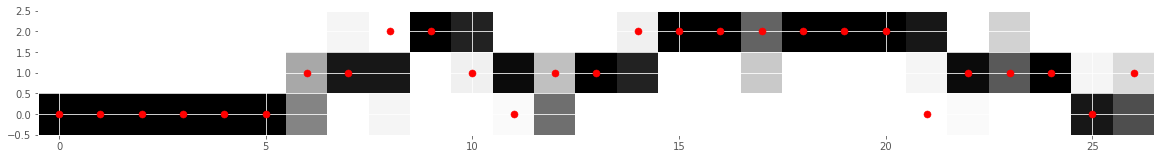

In [78]:
# Limit obs_df to years >= 1993
obs_df = obs_df.query('year >= 1993')

# Assign terciles for each series
obs_df['terc'] = pd.qcut(obs_df['value'], 3, labels=False)

for idx, col in enumerate([f'sim_s5_{i:02d}' for i in range(1, 26)]):
    s5_df[f'terc_{idx+1:02d}'] = pd.qcut(s5_df[col], 3, labels=False)
    
# Extract cols to new dataframes
s5_terc = s5_df[[f'terc_{i:02d}' for i in range(1, 26)]]
obs_terc = obs_df[['terc']]

# Create dataframe of S5 probs for each tercile
s5_probs = pd.DataFrame({0:(s5_terc == 0).sum(axis=1),
                         1:(s5_terc == 1).sum(axis=1),
                         2:(s5_terc == 2).sum(axis=1),
                        }) / 25

# Plot
fig = plt.figure(figsize=(20,10))
plt.imshow(s5_probs.T.values, cmap='Greys', origin='lower')
plt.scatter(range(len(obs_terc['terc'])), obs_terc['terc'], c='r', s=50)